# Cascade Quadrotor

In [9]:
import requests as req, os

URL = "https://raw.githubusercontent.com/mit-acl/16_06_Class/main/"
File = ["basic_material.py","control_materials.py"]

if not os.path.isfile(File[0]):
    print('Basic files not found - downloading them')
    for dfile in File:
        if not os.path.isfile(dfile):
            print("Downloading "+dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()
else:
    print('Basic file found')
from basic_material import *

from control.matlab import tf, rlocus, step, feedback, lsim, bode, ss, tf
s = tf('s')

from control_materials import *

Basic file found


## Quadrotor

In [10]:
# Constants for the model
HL = 0.25
Ix = 0.0077
Iy = 0.0076
g = 9.81

# For simulation model [x xd phi p]
Ap = np.array([[0, 1, 0, 0], [0, 0, g, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
Bp = np.array([[0], [0], [0], [5 * (HL / Iy)]])
Cp = np.eye(4)
Dp = np.zeros((4, 1))

# For simulation model
Aatt = Ap[2:, 2:]
Batt = Bp[2:, :]
Catt = Cp[2:, 2:]
Datt = Dp[2:, :]

# Transfer function to position output
G_att = near_zero(tf(ss(Aatt, Batt, Catt[0, :], Datt[0, 0])))
print(G_att)

G_pos = near_zero(tf(ss(Ap[0:2, 0:2], Ap[0:2, 2], np.array([1,0]), 0)))
print(G_pos)

<TransferFunction>: sys[39]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


164.5
-----
 s^2

<TransferFunction>: sys[42]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


9.81
----
s^2



Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


<TransferFunction>: sys[43]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.1946 s + 2.432
----------------
       1


Found breakin/out at K = 1.562
At possible locations s = -25.000

Found breakin/out at K = -0.000
At possible locations s = 0.000


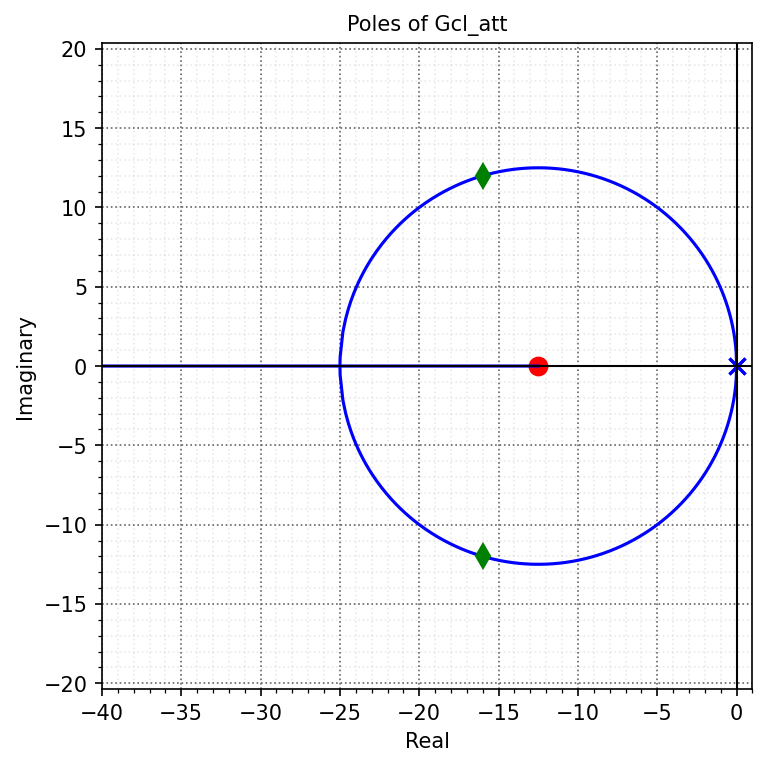

TransferFunction(array([ 400.000]), array([   1.000,   32.000,  400.000]))

In [11]:
# dsign parameters for the controller
Tr = 0.05
wn = 1.0/Tr
zeta = 0.8
# pick gains for the attitude controller
Kp_att = (wn**2/G_att.num[0][0])[0]
Kd_att = (2*zeta*wn/G_att.num[0][0])[0]
PD_att = tf([Kd_att, Kp_att], [1])
print(PD_att)

# Loop TF
L_att = G_att * PD_att

Gcl_att = Kp_att*G_att/(1+G_att*(Kp_att+Kd_att*s))
Gcl_att = tf(np.trim_zeros(Gcl_att.num[0][0], 'b'), np.trim_zeros(Gcl_att.den[0][0], 'b'))

fig, ax = plt.subplots(1,figsize=(5, 5),dpi=150,constrained_layout = True)
rlocus(L_att, Root_Locus_gains(L_att), grid=False,ax=ax,color='b')
plt.plot(Gcl_att.poles().real, Gcl_att.poles().imag, 'rd', markersize=10)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Poles of Gcl_att')
ax.axis('equal')
ax.set_ylim(-20,20)
ax.set_xlim(-40,1)
color_rl(ax)
nicegrid(ax)
savefig("./figs/Quad_step4.pdf", dpi=600)
plt.show()
Gcl_att

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


<TransferFunction>: sys[56]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.3262 s + 0.4077
-----------------
        1

<TransferFunction>: sys[70]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


                 1600
--------------------------------------
s^4 + 32 s^3 + 400 s^2 + 1280 s + 1600


Found breakin/out at K = 1.257
At possible locations s = -2.896

Found breakin/out at K = -0.000
At possible locations s = 0.000


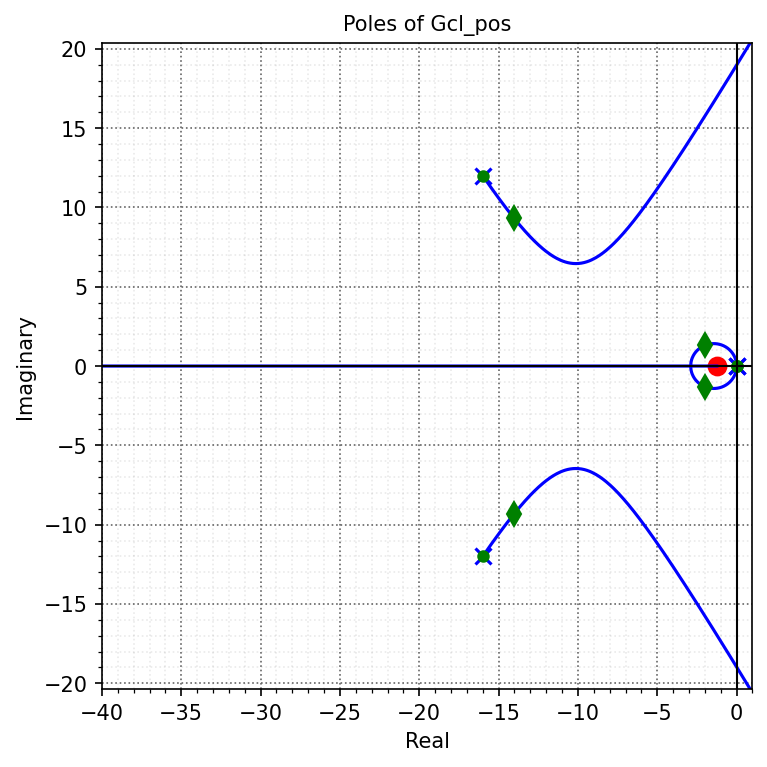

TransferFunction(array([ 1600.000]), array([   1.000,   32.000,  400.000,  1280.000,  1600.000]))

In [12]:
# design parmaeters for the position controller (slower)
wn = 1.0/(10*Tr)
Kp_pos = (wn**2/G_pos.num[0][0])[0]
Kd_pos = (2*zeta*wn/G_pos.num[0][0])[0]
PD_pos = tf([Kd_pos, Kp_pos], [1])
print(PD_pos)

G_inner = Gcl_att*tf([g],[1,0,0])
Gcl_pos = Kp_pos*G_inner/(1+G_inner*(Kp_pos+Kd_pos*s))
Gcl_pos = tf(np.trim_zeros(Gcl_pos.num[0][0], 'b'), np.trim_zeros(Gcl_pos.den[0][0], 'b'))
Gcl_pos = Gcl_pos.minreal()
print(Gcl_pos)

# Loop TF
L_pos = G_inner * PD_pos

fig, ax = plt.subplots(1,figsize=(5, 5),dpi=150,constrained_layout = True)
rlocus(L_pos, Root_Locus_gains(L_pos), grid=False,ax=ax,color='b')
plt.plot(Gcl_pos.poles().real, Gcl_pos.poles().imag, 'gd', markersize=10)
plt.plot(G_inner.poles().real, G_inner.poles().imag, 'g.', markersize=10)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Poles of Gcl_pos')
color_rl(ax)
nicegrid(ax)
ax.axis('equal')
ax.set_ylim(-20,20)
ax.set_xlim(-40,1)
savefig("./figs/Quad_step3.pdf", dpi=600)
plt.show()
Gcl_pos

In [25]:
from scipy.integrate import odeint

K = np.array([Kp_att*Kp_pos, Kp_att*Kd_pos, Kp_att, Kd_att])
Acl = Ap - Bp @ K.reshape(1,4)
Bcl = Bp*Kp_att*Kp_pos

ev = np.linalg.eig(Acl)[0]
pretty_row_print(ev, "Eigenvals of Acl: ")
    
poles = Gcl_pos.poles()
pretty_row_print(poles, "Poles of Gcl_pos: ")

pretty_row_print(K, "Gain K: ")

Eigenvals of Acl: (-14.02 + 9.31i), (-14.02 + -9.31i), (-1.98 + 1.31i), (-1.98 + -1.31i)
Poles of Gcl_pos: (-14.02 + 9.31i), (-14.02 + -9.31i), (-1.98 + 1.31i), (-1.98 + -1.31i)
Gain K: 0.992, 0.793, 2.432, 0.195


In [26]:
def sat(x,xmax):
    return np.clip(x, -xmax, xmax)

# Define the system of differential equations
def system_dynamics(x, t, Ap, Bp, K, xc = 1, saturated = False, max_att_angle = 30):
    # Compute the control input    
    Kp_pos, Kd_pos, Kp_att, Kd_att = K
    pos, v, phi, phidot = x

    phi_c = Kp_pos * (xc - pos) - Kd_pos * v
    if saturated: # attitude angle command saturation
        u = Kp_att * (sat(phi_c, np.deg2rad(max_att_angle)) - phi) - Kd_att * phidot
    else:
        u = Kp_att * (phi_c - phi) - Kd_att * phidot

    dxdt = (Ap @ x + Bp.reshape(1,4) * u)

    return dxdt.flatten()

x0 = np.array([0, 0, 0, 0])
t = np.linspace(0, 6, 2000)
Xc = 1
max_att_angle = 10
saturated = True
x = odeint(system_dynamics, x0, t, args=(Ap, Bp, np.array([Kp_pos, Kd_pos, Kp_att, Kd_att]), Xc, saturated, max_att_angle))

phi_c = Kp_pos * (Xc - x[:,0]) - Kd_pos * x[:,1]
if saturated:
    phi_c = sat(phi_c, np.deg2rad(max_att_angle))


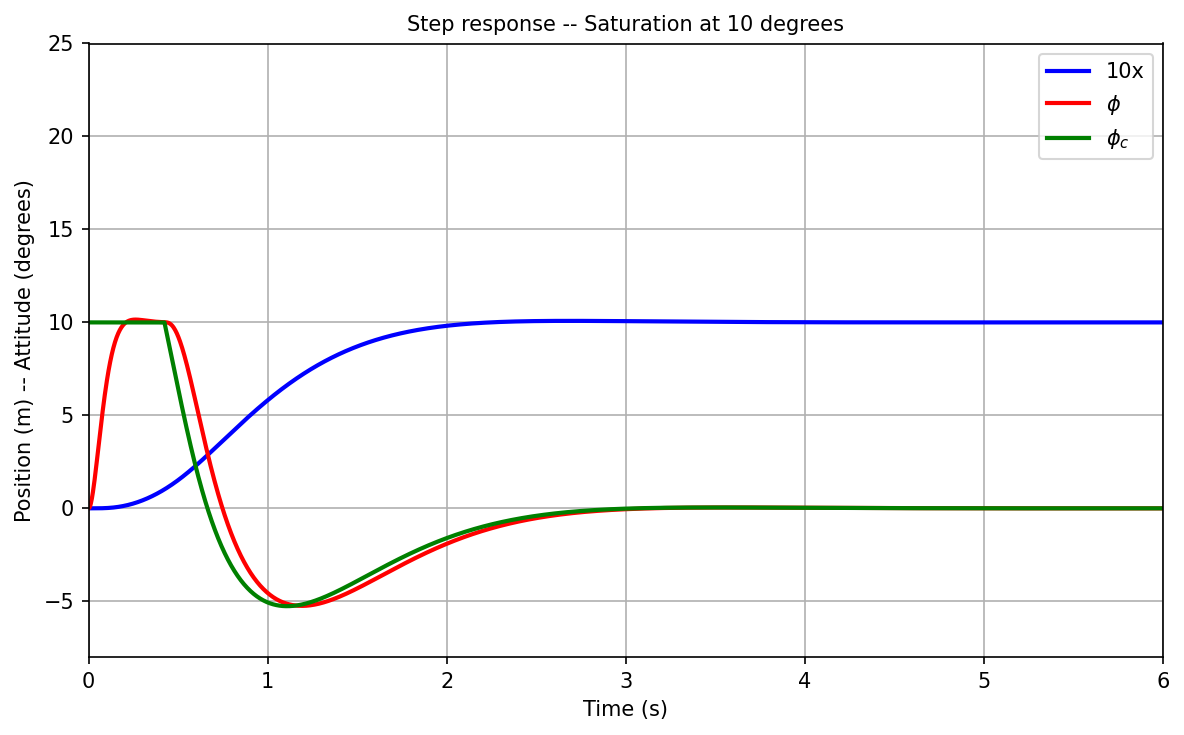

In [27]:
# Plot the results
fig, ax = plt.subplots(1, figsize=(8,5), dpi=150, sharex=True)
ax.plot(t, 10*x[:, 0], 'b', label='10x')
ax.plot(t, np.rad2deg(x[:, 2]), 'r', label=r'$\phi$')
ax.plot(t, np.rad2deg(phi_c), 'g', label=r'$\phi_c$')
ax.set_ylabel('Position (m) -- Attitude (degrees)')
ax.set_xlabel('Time (s)')
ax.legend()
plt.title('Step response of closed-loop system - saturated $\phi_c =$'+str(max_att_angle)+' degrees')
ax.grid(True)
if saturated:
    plt.title('Step response -- Saturation at '+str(max_att_angle)+' degrees')
    savefig("./figs/Quad_step1.pdf", dpi=600)
else:
    plt.title('Step response -- No Saturation')
    savefig("./figs/Quad_step2.pdf", dpi=600)
ax.set_ylim(-8,25)
plt.show()

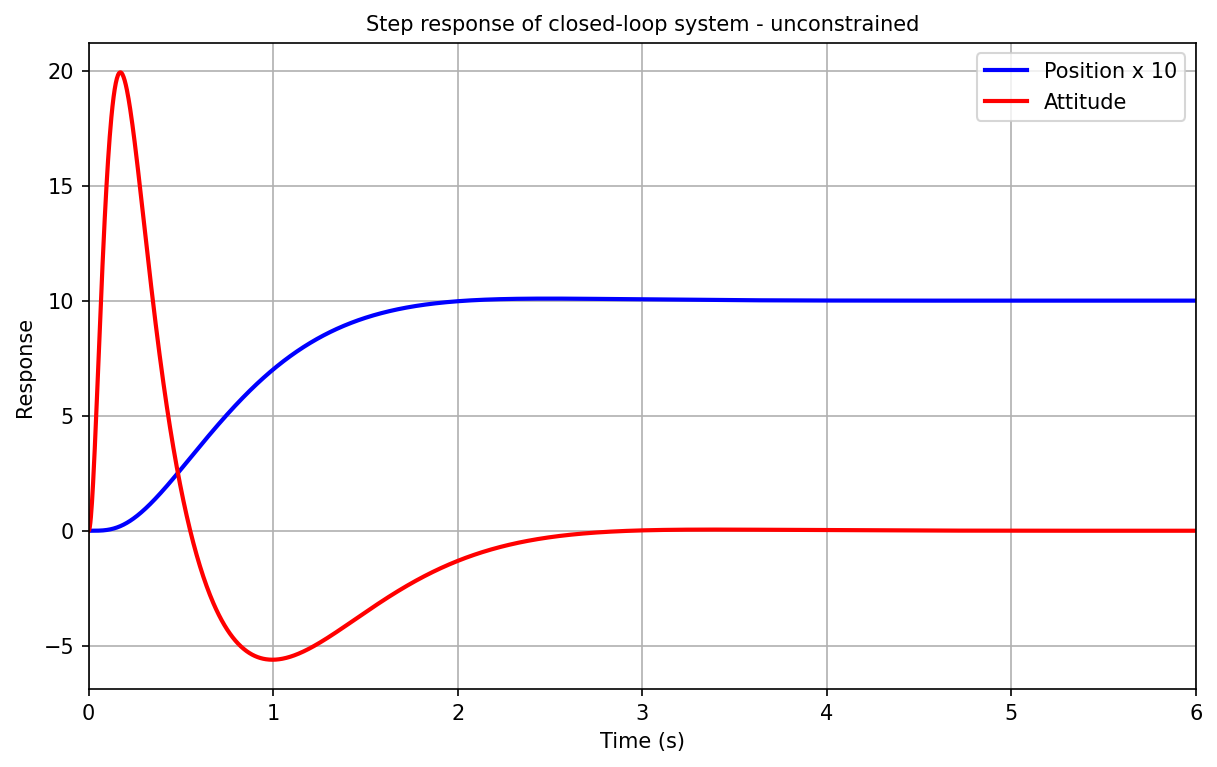

In [28]:
fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,constrained_layout = True)
y_pos,t = step(ss(Acl,Bcl,np.array([1,0,0,0]),0),T=t)
y_att,t = step(ss(Acl,Bcl,np.array([0,0,1,0]),0),T=t)
plt.plot(t,10*y_pos, 'b', label='Position x 10')
plt.plot(t,np.rad2deg(y_att), 'r', label='Attitude')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.title('Step response of closed-loop system - unconstrained')
plt.legend()
savefig("./figs/Quad_step2.pdf", dpi=600)
plt.show()
